<a href="https://colab.research.google.com/github/bscot/TheLastMetric/blob/master/Example_TLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install required libraries

!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install astropy pzflow corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 MB 5.7 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.7-py3-none-any.whl size=1438287 sha256=8b89c1e3337e548a708568f85c5324975810f1177507c285bf0712c46d8082c0
  Stored in directory: /root/.cache/pip/wheels/e9/73/66/a8af684b751f8cf468ce4b76759785559cd0a35e5e2973fd2a
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.6+cuda11.cudnn86
    Uninstalling jaxlib-0.4.6+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.6+cuda11.cudnn86
  Attempting uninstall: jax
    Found existing installation: 

In [48]:
# import statements

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd 
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
import os
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds
from collections import namedtuple

In [3]:
# read in the data

!wget --quiet -O dataset.tar https://drive.google.com/u/0/uc?id=1t9_3GqjFGhpgdjiww6vlmijS-3rgVaC0&export=download
!tar -xf dataset.tar
!mv for_francois dataset

In [4]:
ls dataset/for_francois/

baseline_v1.4_10yrs/  statplot_fout.png              var_expt_v1.4_10yrs/
README.txt            statplot_stdd.png              weather_1.2_v1.4_10yrs/
statplot_bias.png     twilight_neo_mod1_v1.4_10yrs/


In [4]:
from google.colab import drive
drive.mount('/content/drive')
prepend = '/content/drive/MyDrive/Research/RubinPz/'

Mounted at /content/drive


In [49]:
data_dir = '/content/drive/MyDrive/Research/RubinPz/TLMdata/'

In [50]:
all_readme = open(os.path.join(data_dir,'readme.txt')).read().split('\n')
in_metadata = [] 

colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]

for i, line in enumerate(all_readme[0:6]):
  descr = all_readme[i+1].split()
  in_metadata.append(descr)

  metadatum = namedtuple('metadatum', ['runid', 'OpSimName', 'u', 'g', 'r', 'i', 'z', 'y'])

  metadata = {}
  for row in in_metadata:
    metadata[row[0]] = metadatum(*row)

  names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
  names_phot=('ID', 'z_true',
    'u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z', 'y', 'err_y',
    'u-g', 'err_u-g', 'g-r', 'err_g-r', 'r-i', 'err_r-i', 'i-z', 'err_i-z', 'z-y', 'err_z-y')

  available_os = list(metadata.keys())
  names = [metadata[runid].OpSimName for runid in available_os]
  os_names = dict(zip(available_os, names))
  os_colors = dict(zip(available_os, colors))

In [51]:
print(available_os)
print(names)

['1_4_y10', '4_38_y10', '10_92_y10', '4_34_y10', '7_61_y10', '9_86_y10']
['baseline_v1_5_10yrs', 'footprint_stuck_rollingv1_5_10yrs', 'ddf_heavy_nexp2_v1_6_10yrs', 'footprint_newAv1_5_10yrs', 'third_obs_pt60v1_5_10yrs', 'barebones_v1_6_10yrs']


In [52]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')


#available_os = ['baseline_v1.4_10yrs', 'twilight_neo_mod1_v1.4_10yrs', 'var_expt_v1.4_10yrs', 'weather_1.2_v1.4_10yrs']
#os_colors = {'baseline_v1.4_10yrs': 'k', 'twilight_neo_mod1_v1.4_10yrs': '#2ca02c', 'var_expt_v1.4_10yrs': '#1f77b4', 'weather_1.2_v1.4_10yrs': '#ff7f0e'}

     

In [72]:
ls /content/drive/MyDrive/Research/RubinPz/TLMdata/run_4_38_y10

test.cat  zphot.cat


In [73]:
available_os

['1_4_y10', '4_38_y10', '10_92_y10', '4_34_y10', '7_61_y10', '9_86_y10']

In [68]:
names

['baseline_v1_5_10yrs',
 'footprint_stuck_rollingv1_5_10yrs',
 'ddf_heavy_nexp2_v1_6_10yrs',
 'footprint_newAv1_5_10yrs',
 'third_obs_pt60v1_5_10yrs',
 'barebones_v1_6_10yrs']

In [74]:
phot_cats, z_cats = {}, {}

for name, which_os in zip(names, available_os):
  test_cat = Table.read(data_dir+'run_'+which_os+'/test.cat', format='ascii')


  z_cat = Table.read(data_dir+'run_'+which_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read(data_dir+'run_'+which_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[which_os] = phot_cat
  print('phot: ')
  print(len(phot_cats[which_os]))
  z_cats[which_os] = z_cat
  print('z: ')
  print(len(z_cats[which_os]))

phot: 
50000
z: 
50000
phot: 
50000
z: 
50000
phot: 
50000
z: 
50000
phot: 
50000
z: 
50000
phot: 
50000
z: 
50000
phot: 
50000
z: 
50000


In [77]:
which_os

'9_86_y10'

In [76]:
phot_cats[which_os]

ID,z_true,u,g,r,i,z,y,err_u,err_g,err_r,err_i,err_z,err_y,u-g,g-r,r-i,i-z,z-y,err_u-g,err_g-r,err_r-i,err_i-z,err_z-y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5901315,0.16834128,20.628696,0.005,19.749174,0.005,19.248232,0.005,19.083636,0.005,18.970596,0.005,18.923118,0.005,0.879523,0.007071,0.500941,0.007071,0.164596,0.007071,0.11304,0.007071,0.047479,0.007071
1151331,0.9674438,24.42383,0.054462,24.342691,0.019501,23.800588,0.011951,23.010845,0.009764,22.377882,0.008701,22.248657,0.015295,0.081139,0.057848,0.542103,0.022872,0.789742,0.015432,0.632963,0.013079,0.129225,0.017597
12252497,1.2806695,24.661739,0.064666,24.950809,0.030086,24.491336,0.020555,23.92585,0.020136,23.194683,0.018491,22.815311,0.025808,-0.28907,0.071323,0.459474,0.036437,0.565485,0.028774,0.731167,0.027338,0.379372,0.031748
3597887,0.45177186,22.011683,0.009958,21.672854,0.005,20.694732,0.005,20.458205,0.005,20.297752,0.005,20.250378,0.005,0.338829,0.011143,0.978122,0.007071,0.236527,0.007071,0.160453,0.007071,0.047375,0.007071
9305575,0.85668314,23.940226,0.034099,23.918341,0.014428,23.767213,0.011776,23.095266,0.010343,22.907809,0.014127,22.901075,0.027236,0.021885,0.037026,0.151128,0.018624,0.671947,0.015673,0.187457,0.017509,0.006734,0.030682
6925867,0.7054503,24.509896,0.056894,24.5146,0.022602,24.227738,0.016934,23.682591,0.016134,23.691313,0.028298,23.652829,0.055103,-0.004704,0.061219,0.286863,0.028242,0.545147,0.023389,-0.008722,0.032574,0.038484,0.061945
4659644,1.1382225,23.957348,0.035298,24.073371,0.015717,23.97845,0.013656,23.831403,0.017639,23.069245,0.017228,22.996621,0.031116,-0.116023,0.038639,0.094921,0.020821,0.147047,0.022308,0.762158,0.024656,0.072624,0.035567
12393128,0.666667,23.839893,0.032585,23.726984,0.012653,23.249585,0.007957,22.692187,0.007661,22.581873,0.010501,22.475374,0.019709,0.112908,0.034956,0.477399,0.014947,0.557399,0.011046,0.110314,0.012999,0.106499,0.022332
9550995,0.71089447,22.952541,0.017698,22.796071,0.007062,22.294075,0.005,21.591849,0.005,21.42014,0.005,21.35054,0.006596,0.15647,0.019055,0.501997,0.008653,0.702226,0.007071,0.171709,0.007071,0.0696,0.008277


In [22]:
#IDS = phot_cats[available_os[1]]['ID']

In [26]:
#IDS = phot_cats[available_os[1]]['ID']

#z_cats[available_os[1]].to_pandas()[z_cats[available_os[1]].to_pandas()['ID'].isin(IDS)]

,ID,z_true,z_phot,dz_phot,NN,N_train
0,1198255,0.811061,0.792757,0.021096,306,121600
1,8087855,0.266076,0.266076,0.008419,10,117907
2,13374390,1.330510,1.621435,0.129724,4915,123739
4,13154811,1.705116,1.771119,0.108593,3642,101655
5,5401341,1.118003,1.255187,0.067334,1445,142896
...,...,...,...,...,...,...
49995,6459114,1.465331,1.607332,0.156788,13021,145722
49996,10609198,1.720646,1.680949,0.059244,548,33582
49997,1933684,0.125767,2.267096,1.189166,2498,109786
49998,13516144,1.412769,1.393957,0.080412,215,161753


In [80]:
drop_cols = ['ID', 'z_true', 'u', 'g',  'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y']


In [9]:
#phot_cats['baseline_v1.4_10yrs']

In [10]:
#phot_cats['baseline_v1.4_10yrs'].to_pandas().drop(drop_cols, axis = 1)

In [ ]:
# conditional_columns = phot_cats['baseline_v1.4_10yrs'].to_pandas().drop(drop_cols, axis = 1)

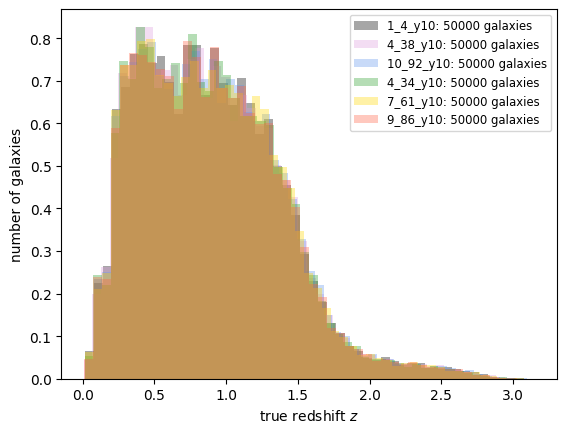

In [78]:
from matplotlib.pyplot import hist, xlabel, ylabel, legend 

for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=50, alpha=0.35, color=os_colors[which_os], 
       label=which_os+': '+str(len(phot_cats[which_os]))+' galaxies', density = True)
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')

In [ ]:
# up to this point, using exact routines from TLM - switching to CASTOR inherited scripts

In [81]:
# mins = [0, 20, -5, -5, -5, -5, -5]
# maxs = [6, 30, 5, 5, 5, 5, 5]

# the data column is the one that is sampled and transformed by the flow
data_columns = ["z_true"]

all_cond_cols = {}
ensembles = dict()

for which_os in available_os:#catalogs.keys():
 # the conditional columns are the columns that the flow is conditioned on
  #conditional_columns = phot_cats[os].columns.drop('z_true')#["r", "g-r", "r-i", "i-z"] #, "uv-u", "u-g"] # different colors than LSST
  conditional_columns = phot_cats[which_os].to_pandas().drop(drop_cols, axis = 1)
  all_cond_cols[os] = conditional_columns
  # print((os, conditional_columns))
  ndcol = len(data_columns)
  ncond = len(conditional_columns)
  ndim = ndcol+ncond

# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
# bijector = Chain(
#     StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
#     NeuralSplineCoupling(n_conditions=6)
# )
#   bijector = Chain(
#     # InvSoftplus(z_col, sharpness),
#     ShiftBounds(0, 6, B=4),
#     RollingSplineCoupling(nlayers=1, n_conditions=ncond, B=6),
#   )

  bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=6)
  )

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
# latent = Uniform(1, 5) # did the syntax here change?

  latent = Uniform(input_dim=ndcol, B=7)#(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5))

  flowEns2 = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                          #  info = info#, 
                          #  N = 10
                            )
  ensembles[os] = flowEns2

In [38]:
ensembles

{}

In [39]:
# # temporary

# from google.colab import drive
# drive.mount('/content/drive')
# prepend = '/content/drive/MyDrive/Research/RubinPz/'

In [40]:
# ls '/content/drive/MyDrive/Research/RubinPz/'

In [36]:
# tav_train, tav_test = {}, {}
# available_os = ['weather_1.2_v1.4_10yrs']

for which_os in available_os:#:
    ens  = ensembles[which_os]
    # get the data and make a train and test set
    cat = phot_cats[which_os].to_pandas()
    # cat_train = cat.sample(frac = 0.99)
    # cat_test = cat.drop(cat_train.index)
    cat_train = cat
    print(which_os)
    # train the flow on the given learning rate schedule
    loss = ens.train(cat_train,#conditional_columns], 
                               convolve_errs=False,
                       epochs = 150, verbose=True)
    # loss2 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 312)
    # loss3 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 231)
    
    # losses = {fname : # for each flow trained in the ensemble...
    #               [float(loss) # save the list of training losses
    #                for lossDict in [loss1]#, loss2, loss3]
    #                for loss in lossDict[fname]]
    #           for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    # test_loss = -np.mean(ens.log_prob(cat_test))
    print(which_os, train_loss)#, test_loss)
    # post_trained[os] = ens
    # save the ensemble
    ens.save(prepend+f"pzflow_ensemble_for_{which_os}.pkl")
    # and the losses
    with open(prepend+f"losses_for_{which_os}.pkl", "wb") as file:
        pickle.dump({"losses": loss, 
                     "train loss": train_loss, 
                    #  "test loss": test_loss,
                     "train_ids": cat_train.index},
                    file)
        
    # mutual_information_lower_bound_train = ens.log_prob(cat_train, returnEnsemble=True)
    # mutual_information_lower_bound_test = ens.log_prob(cat_test, returnEnsemble=True)
    # tav_train[os] = mutual_information_lower_bound_train
    # tav_test[os] = mutual_information_lower_bound_test


NameError: ignored

In [17]:
cd drive/MyDrive/Research/RubinPz

/content/drive/MyDrive/Research/RubinPz


In [18]:
pwd

'/content/drive/MyDrive/Research/RubinPz'

In [19]:
# losses_for_baseline_v1.4_10yrs.pkl
# losses_for_twilight_neo_mod1_v1.4_10yrs.pkl
# losses_for_var_expt_v1.4_10yrs.pkl
# losses_for_weather_1.2_v1.4_10yrs.pkl
# pzflow_ensemble_for_baseline_v1.4_10yrs.pkl
# pzflow_ensemble_for_twilight_neo_mod1_v1.4_10yrs.pkl
# pzflow_ensemble_for_var_expt_v1.4_10yrs.pkl
# pzflow_ensemble_for_weather_1.2_v1.4_10yrs.pkl

SyntaxError: ignored

In [20]:
flows = {}
for os in available_os:
  flows[os] = [FlowEnsemble(file=f"pzflow_ensemble_for_{os}.pkl" )]

# just_tav = {}
# for os in available_os:
#   just_tav[os] = post_trained[os].log_prob(catalogs[os])

flows

{'baseline_v1.4_10yrs': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f842d8c6df0>],
 'twilight_neo_mod1_v1.4_10yrs': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f842d8c6ee0>],
 'var_expt_v1.4_10yrs': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f8424acff40>],
 'weather_1.2_v1.4_10yrs': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f8429086dc0>]}

In [21]:
all_logp = {}
for which_os in available_os:
  all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
                                 for f in flows[which_os] ], axis=0)

In [ ]:
zbins = np.linspace(0, 3, 32)
avgtav = {}
errtav = {}
for which_os in available_os:
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  if 'logprob' not in phot_cats[which_os].columns.values():
    phot_cats[which_os]['logprob'] = all_logp[which_os]
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = phot_cats[which_os][(phot_cats[which_os]['z_true'] >= zmin) & (phot_cats[which_os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr



weather_1.2_v1.4_10yrs
<TableColumns names=('ID','z_true','u','g','r','i','z','y','err_u','err_g','err_r','err_i','err_z','err_y','u-g','g-r','r-i','i-z','z-y','err_u-g','err_g-r','err_r-i','err_i-z','err_z-y','logprob')>
<TableColumns names=('ID','z_true','u','g','r','i','z','y','err_u','err_g','err_r','err_i','err_z','err_y','u-g','g-r','r-i','i-z','z-y','err_u-g','err_g-r','err_r-i','err_i-z','err_z-y','logprob')>
weather_1.2_v1.4_10yrs
<TableColumns names=('ID','z_true','u','g','r','i','z','y','err_u','err_g','err_r','err_i','err_z','err_y','u-g','g-r','r-i','i-z','z-y','err_u-g','err_g-r','err_r-i','err_i-z','err_z-y')>


In [1]:
for which_os in available_os:
  plt.errorbar(zbins, avgtav[which_os], errtav[which_os], label=which_os, alpha=0.5)
plt.legend()
plt.xlabel('z_true')
plt.ylabel(chr(0x05ea))

NameError: ignored

In [14]:
z_cats_no_nan = {}
for which_os in available_os: 
  IDS = phot_cats[which_os]['ID']
  z_cats_no_nan[which_os] = z_cats[which_os].to_pandas()[z_cats[which_os].to_pandas()['ID'].isin(IDS)]

46122
46122


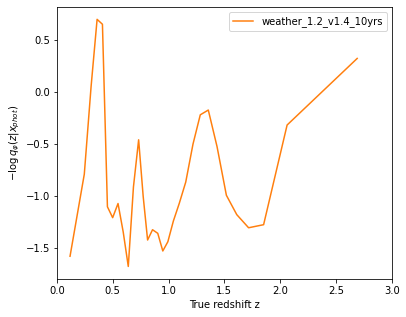

In [27]:
# all_logp = {}
# for which_os in available_os:
#   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
#                                  for f in flows[which_os] ], axis=0)

from scipy import stats
n=32
b = stats.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
print(len(z_cats_no_nan[which_os]['z_true']))

mis = {}

for which_os in available_os:
  inds = np.digitize(z_cats_no_nan[which_os]['z_true'], b) -1 

  print(len(inds))


  res = np.zeros(n-1)
  for i in range(n-1):
    res[i] = np.mean( np.mean((all_logp[which_os].flatten()[inds == i])))
    
  mis[which_os] = res

b_centers = 0.5*(b[1:] + b[:-1])

plt.figure(figsize=(6,5))
for which_os in available_os:
  plt.plot(b_centers, - mis[which_os], label=which_os, color=os_colors[which_os])
plt.legend()
plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$')
plt.xlabel('True redshift z')
plt.xlim(0,3);


In [2]:
z_cats['baseline_v1.4_10yrs'].to_pandas().dropna()

NameError: ignored

In [1]:
z_cats['ID']

NameError: ignored

In [9]:
phot_cats['baseline_v1.4_10yrs'].to_pandas().dropna()

,ID,z_true,u,g,r,i,z,y,err_u,err_g,...,u-g,g-r,r-i,i-z,z-y,err_u-g,err_g-r,err_r-i,err_i-z,err_z-y
0,5142370,1.611490,24.121025,0.053106,24.084064,0.021194,24.181071,0.020409,24.123542,0.028792,...,0.036961,0.057179,-0.097007,0.029423,0.057529,0.035292,0.188057,0.052722,0.260121,0.086867
1,10264978,0.609370,25.452115,0.146893,25.112487,0.047829,24.362166,0.023850,23.863323,0.024224,...,0.339628,0.154484,0.750321,0.053446,0.498843,0.033995,0.141730,0.044184,-0.015132,0.081144
2,14377082,1.458934,24.812845,0.099648,24.708982,0.036467,24.659695,0.031157,24.417965,0.036453,...,0.103862,0.106111,0.049287,0.047964,0.241730,0.047954,0.505887,0.055536,0.402858,0.070597
3,1763375,0.831793,25.239161,0.167837,25.307067,0.062421,25.126998,0.046350,24.424180,0.036193,...,-0.067906,0.179069,0.180069,0.077747,0.702819,0.058807,0.303500,0.063029,-0.011151,0.113981
4,7447092,1.607346,24.761218,0.101785,24.784247,0.037954,24.998465,0.040439,24.650014,0.051406,...,-0.023029,0.108630,-0.214218,0.055460,0.348451,0.065405,0.182749,0.089865,-0.012705,0.140346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45462,14397855,0.617293,22.352280,0.015766,22.080703,0.005925,21.379873,0.005000,20.870425,0.005000,...,0.271577,0.016842,0.700831,0.007753,0.509448,0.007071,0.137748,0.007071,0.077302,0.007071
45463,7802797,1.407002,24.310817,0.066381,24.540088,0.029989,24.541476,0.028616,24.461149,0.040457,...,-0.229271,0.072840,-0.001388,0.041451,0.080327,0.049555,0.140659,0.070073,0.436596,0.105000
45464,13596631,1.027984,24.827324,0.112767,25.006379,0.046138,24.982716,0.040795,24.726936,0.046983,...,-0.179055,0.121841,0.023662,0.061587,0.255780,0.062222,0.532797,0.071797,0.172554,0.121514
45465,2249420,0.599738,24.377532,0.076603,24.348074,0.025946,23.578580,0.012675,23.085684,0.012725,...,0.029458,0.080878,0.769493,0.028877,0.492897,0.017961,0.157233,0.021593,0.060149,0.038260


In [11]:
Table.from_pandas(z_cats['baseline_v1.4_10yrs'].to_pandas().dropna())

ID,z_true,z_phot,dz_phot,NN,N_train
int64,float64,float64,float64,int64,int64
5142370,1.61149,1.6217439,0.11353139,1364,137633
10264978,0.6093701,0.5959976,0.01916667,4299,100392
5218585,1.6459169,1.805623,0.19234595,7424,122780
11234975,0.9162506,0.9486344,0.03908415,17940,171801
14377082,1.4589336,1.3392558,0.0723988,3084,165974
1763375,0.8317933,0.8913735,0.0407313,18254,120332
7447092,1.6073463,1.6826489,0.10704371,1147,99669
10216960,0.37455308,0.37172663,0.05117984,7242,94588
8482528,1.7008493,1.6734085,0.05757779,191,26721


In [12]:
data_url="https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz"

def load_data(output_dir='dataset'):
  """Retrieves opsim data from the internets if not already available locally
  """
  if not os.path.exists(output_dir):
    # Create a temporary work directory
    temp_path = tempfile.mkdtemp()
    tar_filename = os.path.join(temp_path, 'archive.tar.gz')

    # Download the archive from the cloud
    request.urlretrieve(data_url, tar_filename)

    # Extract archive
    my_tar = tarfile.open(tar_filename)
    my_tar.extractall(temp_path)

    # Move directory
    shutil.move(os.path.join(temp_path, 'for_malz_and_lanusse'),
                output_dir)

  # Now we can load the data
  all_readme = open(os.path.join(output_dir,'readme.txt')).read().split('\n')
  in_metadata = []
  for i, line in enumerate(all_readme[0:6]):
    descr = all_readme[i+1].split()
    in_metadata.append(descr)

  metadatum = namedtuple('metadatum', ['runid', 'OpSimName', 'u', 'g', 'r', 'i', 'z', 'y'])

  metadata = {}
  for row in in_metadata:
    metadata[row[0]] = metadatum(*row)

  names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
  names_phot=('ID', 'z_true',
    'u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z', 'y', 'err_y',
    'u-g', 'err_u-g', 'g-r', 'err_g-r', 'r-i', 'err_r-i', 'i-z', 'err_i-z', 'z-y', 'err_z-y')

  available_os = list(metadata.keys())
  names = [metadata[runid].OpSimName for runid in available_os]
  os_names = dict(zip(available_os, names))
  os_colors = dict(zip(available_os, colors))

  phot_cats, z_cats = {}, {}
  for an_os in available_os:
    one_os = 'run_'+an_os
    test_cat = Table.read(os.path.join(output_dir,one_os+'/test.cat'),
                          format='ascii')

    z_cat = Table.read(os.path.join(output_dir,one_os+'/zphot.cat'),
                         format='ascii',
                         names=names_z)

    phot_cat = Table.read(os.path.join(output_dir,one_os+'/test.cat'),
                         format='ascii',
                         names=names_phot)
    phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
    phot_cats[an_os] = phot_cat
    limmags = []
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
      limmags.append(max(phot_cat[band]))
    limmag = metadatum(an_os, os_names[an_os], *limmags)
    z_cats[an_os] = z_cat

  return z_cats, phot_cats, available_os, os_names, os_colors


In [14]:
import os

load_data()

FileNotFoundError: ignored